In [1]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import os
import pandas as pd
import numpy as np
import rpy2.robjects as ro
import sys

import scanpy as sc
import matplotlib.pyplot as plt

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
%%R
options(future.globals.maxSize = 1000000 * 1024^2)
set.seed(2422012)

# Single cell libraries
library(Seurat)
library(sctransform)
library(rliger)
library(SeuratWrappers)
library(conos)
library(scater)
library(scDblFinder)
library(scran)
library(sctransform)
library(scry)

# Rest libraries
library(BiocParallel)
library(ggplot2)
library(dplyr)
library(cowplot)

library(scCustomize)
library(stringr)
library(dittoSeq)
library(DESeq2)
library(enrichR)

library(tidyverse)
library(org.Hs.eg.db)
library(clusterProfiler)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    -- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v tibble  3.2.0     v purrr   1.0.1
v tidyr   1.3.0     v forcats 1.0.0
v readr   2.1.3     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tibble::as_data_frame() masks dplyr::as_data_frame(), igraph::as_data_frame()
x dplyr::collapse()       masks IRanges::collapse()
x dplyr::combine()        masks Biobase::combine(), BiocGenerics::combine()
x purrr::compose()        masks igraph::compose()
x dplyr::count()          masks matrixStats::count()
x tidyr::crossing()       masks igraph::crossing()
x dplyr::desc()           masks IRanges::desc()
x tidyr::expand()         masks S4Vectors::expand(), Matrix::expand()
x dplyr::filter()         masks stats::filter()
x dplyr::first()       

In [3]:
CellType="CCR7mCD45ROm"
title_plot = "CD45RO-CCR7-"

In [4]:
projectdir = "C:/Users/kyria.000/Documents/PhD/Projects/Feng2023/CoPImmunoPD/"
datadir = projectdir + "Data/"
objtdir = projectdir + "Result/Differnetial_Expression_pct_03/"

resultdir = projectdir + "Result/Differnetial_Expression_pct_03/"+CellType+"/"
adata_file = 'AnnData_Integrated.h5ad'


In [5]:
%%R -i projectdir
setwd(projectdir)

In [6]:
%%R -i objtdir -i resultdir -i projectdir
# setwd(projectdir)
dir.create(objtdir)
dir.create(resultdir)
Subbbb <- readRDS(paste0(projectdir,"Subset_raarranged.rds"))

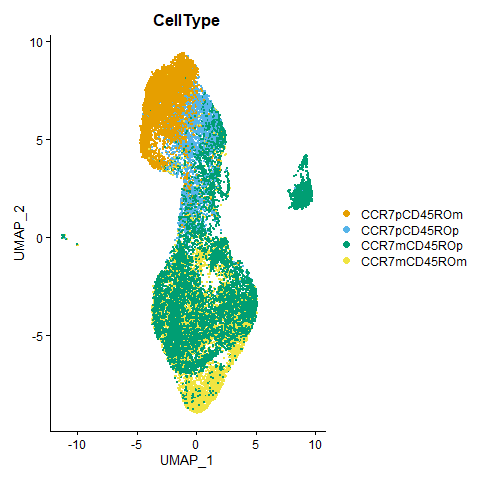

In [7]:
%%R -i resultdir -i projectdir
DimPlot(Subbbb,group.by="CellType",cols=c(dittoColors(1)[seq_len(4)]))

In [8]:
%%R
DefaultAssay(Subbbb) <- "SCT"
# ====== Find markers parameters  ==============
min_pct_threshold = 0.3
# ====== Go enrichment parameters ==============
logfc.threshold <- 0.25
p.val.cutoff <- 0.05
max.genes <- 500


# Subset different CD8 T cells

In [9]:
%%R -i CellType
# ====================== CCR7mCD45ROp ================================
Seurat = subset(Subbbb, idents = CellType)
Seurat<- SetIdent(Seurat , value = "Condition")
Seurat <- PrepSCTFindMarkers(Seurat)

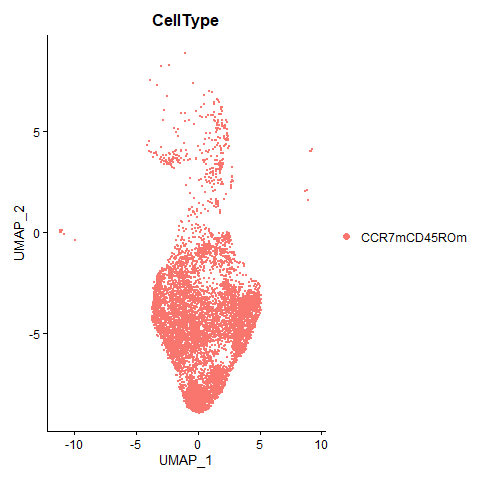

In [10]:
%%R
DimPlot(Seurat,group.by="CellType")

# Create Average Expression

In [11]:
%%R
source(paste0(projectdir,"Functions.R"))

In [12]:
%%R -i resultdir -i CellType
Idents(Seurat) <- "Condition"
Average_Seurat <- AverageExpression(Seurat,return.seurat=T)
Average_Seurat_norm <- as.data.frame(Average_Seurat@assays$SCT@data)
rownames(Average_Seurat_norm) <- rownames(Average_Seurat)
colnames(Average_Seurat_norm)<- paste0(rownames(Average_Seurat@meta.data),"_norm")
Average_Seurat_counts <- as.data.frame(Average_Seurat@assays$RNA@data)
rownames(Average_Seurat_counts) <- rownames(Average_Seurat)
colnames(Average_Seurat_counts)<- paste0(rownames(Average_Seurat@meta.data),"_counts")
Average_Seurat <- as.data.frame(cbind(Average_Seurat_counts,Average_Seurat_norm))
write.csv(Average_Seurat,paste0(resultdir,"Average_",CellType,".csv"))


# Differential Expression

In [13]:
%%R
DE_Seurat_original <-  FindMarkers(Seurat,ident.1="PD",ident.2="HC",
    min.pct = min_pct_threshold,
    logfc.threshold = 0
    )

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01m 17s       |++                                                | 2 % ~01m 15s       |++                                                | 3 % ~01m 12s       |+++                                               | 4 % ~01m 09s       |+++                                               | 5 % ~01m 06s       |++++                                              | 6 % ~01m 05s       |++++                                              | 7 % ~01m 05s       |+++++                                             | 8 % ~01m 04s       |+++++                                             | 9 % ~01m 03s       |++++++                                            | 10% ~01m 02s       |++++++                                            | 11% ~01m 01s       |+++++++                                           | 12% ~60s           |+++++++                                           | 13% ~59s 

In [14]:
%%R
source("Functions.R")
DE_Seurat <- DE_Seurat_original
DE_Seurat$gene <-  rownames(DE_Seurat)
DE_Seurat  <- gene_score_calc(DE_Seurat)


# ADD ENSEMBL IDs

In [15]:
%%R -i projectdir
gene_names <- as.data.frame(readr::read_tsv(paste0(projectdir,"features.tsv"),col_names =F))
colnames(gene_names) <- c("ensembl.id","gene.name","Type")
DE_Seurat$gene.name <- DE_Seurat$gene


remain_ensembl.id <- gene_names[gene_names$gene.name %in% DE_Seurat$gene.name,]
doublicated_gene <- duplicated(remain_ensembl.id$gene.name)
remain_ensembl.id2 <- remain_ensembl.id[!doublicated_gene,]
rownames(remain_ensembl.id2) <- remain_ensembl.id2$gene.name
DE_Seurat$ensembl.id <- remain_ensembl.id2[DE_Seurat$gene.name,"ensembl.id"]
print(DE_Seurat[1:5,])


Rows: 36601 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): X1, X2, X3

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
             gene     tstat gene.score p_val p_val_adj diff.pct
CNOT6L     CNOT6L -320.0000   -1.36618     0         0   -0.165
SAMSN1     SAMSN1 -301.4853   -3.50395     0         0   -0.397
PPP1R16B PPP1R16B -261.2456   -1.36446     0         0   -0.281
GNLY         GNLY  220.5115    2.61484     0         0    0.331
P2RY8       P2RY8 -184.9007   -1.26162     0         0   -0.264
         enrichment.ratio pct.1 pct.2 avg_log2FC cluster gene.name
CNOT6L            1.20886 0.790 0.955   -1.13014      HC    CNOT6L
SAMSN1            4.28096 0.121 0.518   -0.81850      HC    SAMSN1
PPP1R16B          1.45249 0.621 0.902   -0.93939      HC  PPP1R16B
GNLY              1.86649 0.713 0.382    1.40094     

# ADD ENTREZ IDs

In [16]:
%%R
source("Functions.R")
rownames(DE_Seurat) <- DE_Seurat$gene.name
geneIDs <- DE_Seurat[,c("gene.name","ensembl.id")]
DE_Seurat_mapped <- entrezMapper(DEGenes=DE_Seurat, geneIDs=geneIDs, species="hsa")



FALSE  TRUE 
 2611    16 


In [17]:
%%R
cleanDEGenes <- DE_Seurat_mapped[!is.na(DE_Seurat_mapped$entrezID),]
print(dim(cleanDEGenes))
print(dim(DE_Seurat_mapped))

[1] 2611   14
[1] 2627   14


In [18]:
%%R
DE_Seurat_signif <- cleanDEGenes %>%
  filter(abs(avg_log2FC)>0.25 &  p_val_adj <0.05) %>%
  arrange(desc(gene.score))
DE_Seurat_signif[1:5,]

             gene     tstat gene.score p_val p_val_adj diff.pct
GNLY         GNLY 220.51154    2.61484     0         0    0.331
THEMIS     THEMIS  93.63955    1.14083     0         0    0.171
HLA-DRB1 HLA-DRB1  80.99487    1.08137     0         0    0.172
CD74         CD74 107.18943    1.05197     0         0    0.099
ST6GAL1   ST6GAL1  90.07631    1.00078     0         0    0.191
         enrichment.ratio pct.1 pct.2 avg_log2FC cluster gene.name
GNLY              1.86649 0.713 0.382    1.40094      PD      GNLY
THEMIS            1.34969 0.660 0.489    0.84525      PD    THEMIS
HLA-DRB1          1.46612 0.541 0.369    0.73757

      PD  HLA-DRB1
CD74              1.15789 0.726 0.627    0.90852      PD      CD74
ST6GAL1           1.43212 0.633 0.442    0.69881      PD   ST6GAL1
              ensembl.id entrezID
GNLY     ENSG00000115523    10578
THEMIS   ENSG00000172673   387357
HLA-DRB1 ENSG00000196126     3123
CD74     ENSG00000019582      972
ST6GAL1  ENSG00000073849     6480


In [19]:
%%R -i CellType
Average_subset_ordered <- Average_Seurat[DE_Seurat$gene,]
DE_Seurat <- as.data.frame(cbind(DE_Seurat,Average_subset_ordered))
DE_Seurat <- DE_Seurat[order(DE_Seurat$gene.score,decreasing=T),]
readr::write_csv(DE_Seurat,
    file=paste0(resultdir,CellType,"DEG_MinPct_",min_pct_threshold,".csv"))


In [24]:
%%R
library(extrafont)
par(family = "arial")
keyvals.shape <- ifelse( DE_Seurat_original$p_val_adj < 0.05 , 1, 6)
keyvals.shape

   [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [186] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [223] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [260] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [297] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [334] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [371] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [408] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [445] 1 1 1 1 1 1 1 1 1 1 1

Saving 6.67 x 6.67 in image


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


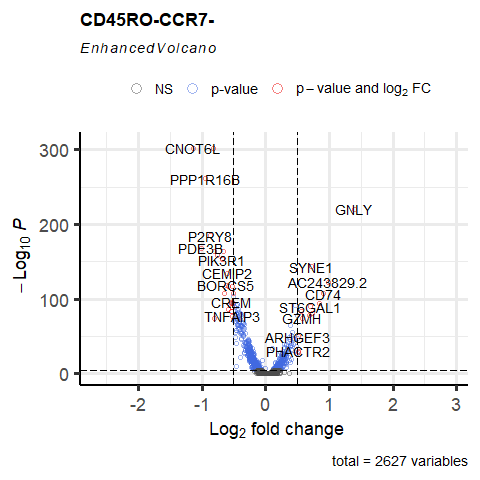

In [37]:
%%R -i resultdir -i title_plot
library(EnhancedVolcano)

# keyvals.shape <- ifelse( DE_Seurat_original$p_val_adj < 0.05 , 1, 6)
# keyvals.shape <- ifelse(
#     res$log2FoldChange < -2.5, 6,
#       ifelse(res$log2FoldChange > 2.5, 6,    'black'))

p <- EnhancedVolcano(DE_Seurat_original,
    lab = rownames(DE_Seurat_original),
    x = 'avg_log2FC',
    y = 'p_val',
    FCcutoff = 0.5,
    title=title_plot,
    pointSize = 3.0,
    labSize = 6.0,
    colAlpha = 1,
    shape = 1)
ggsave(plot=p,filename=paste0(resultdir,CellType,"_Volcano_pct",min_pct_threshold,"_pvalue.png"))
ggsave(plot=p,filename=paste0(resultdir,CellType,"_Volcano_pct",min_pct_threshold,"_pvalue.pdf"))
p

p <- EnhancedVolcano(DE_Seurat_original,
    lab = rownames(DE_Seurat_original),
    x = 'avg_log2FC',
    y = 'p_val_adj',
    FCcutoff = 0.5,
    title=title_plot,
    shape =1)
ggsave(plot=p,filename=paste0(resultdir,CellType,"_Volcano_pct",min_pct_threshold,"_adjustedp.png"))
ggsave(plot=p,filename=paste0(resultdir,CellType,"_Volcano_pct",min_pct_threshold,"_adjustedp.pdf"))
p

# Kegg Pathway

## Possitive PD

In [21]:
%%R
source("Functions.R")
enrich.database <- c("KEGG_2021_Human")
mypos <- enrichR_wrap_fun_pos(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
pos.markers <- mypos$pos.markers
# ======= Enrichment matrix ===================
pos_mat <- mypos$pos_mat
print(pos_mat[1:3,1:2])
kegg_pos_mat <- pos_mat  
readr::write_csv(pos_mat,
    file=paste0(resultdir,CellType,"_POS_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))


Uploading data to Enrichr... Done.
  Querying KEGG_2021_Human... Done.
Parsing results... Done.
                       KEGG_2021_Human.Term KEGG_2021_Human.Overlap
1                         Viral myocarditis              ratio 7/60
2 Natural killer cell mediated cytotoxicity             ratio 8/131
3   Human T-cell leukemia virus 1 infection             ratio 9/219


In [22]:
%%R
print("Take a break enrichr crashes")


[1] "Take a break enrichr crashes"


## Negative PD

In [25]:
%%R
source("Functions.R")
enrich.database <- c("KEGG_2021_Human")
myneg <- enrichR_wrap_fun_neg(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
neg.markers <- myneg$neg.markers
# ======= Enrichment matrix ===================
neg_mat <- myneg$neg_mat
print(neg_mat[1:3,1:2])
kegg_neg_mat <- neg_mat  
readr::write_csv(neg_mat,
    file=paste0(resultdir,CellType,"_NEG_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))

Uploading data to Enrichr... 

Done.
  Querying KEGG_2021_Human... Done.
Parsing results... Done.
        KEGG_2021_Human.Term KEGG_2021_Human.Overlap
1 Osteoclast differentiation            ratio 13/127
2                Hepatitis B            ratio 13/162
3     cAMP signaling pathway            ratio 14/216


Saving 12 x 6.67 in image
Saving 12 x 6.67 in image


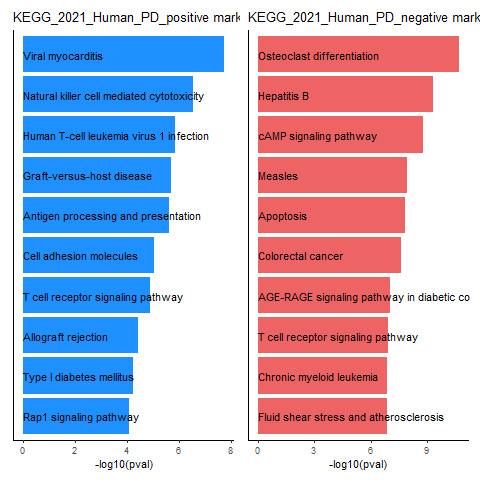

In [26]:
%%R
enrich.database <- "KEGG_2021_Human"
p <- plot_enrichR_wrap_fun(
        ident.1="PD",
        ident.2="HC",
        pos.er = kegg_pos_mat,
        neg.er = kegg_neg_mat,
        enrich.database= enrich.database )


ggsave(plot=p,filename=paste0(resultdir,"BarPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=12)
ggsave(plot=p,filename=paste0(resultdir,"BarPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=12)
p

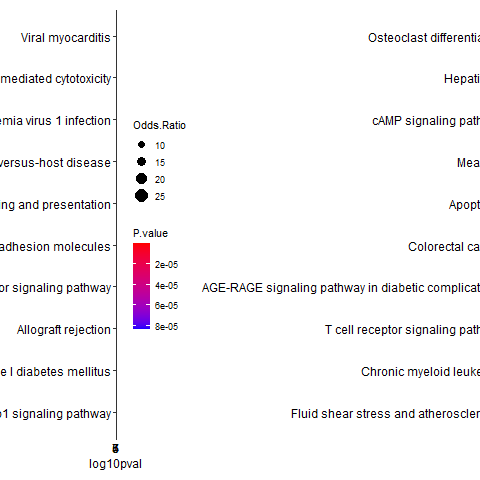

In [27]:
%%R
source("Functions.R")
enrich.database <- "KEGG_2021_Human"
p <- dotplot_enrich_dim(pos_mat=kegg_pos_mat , neg_mat=kegg_neg_mat,n_paths=10)

ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=20,height=6)
ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=20,height=6)

p



# Reactome Pathway

## Possitive PD

In [28]:
%%R
source("Functions.R")
enrich.database <- c("Reactome_2022")
mypos <- enrichR_wrap_fun_pos(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
pos.markers <- mypos$pos.markers
# ======= Enrichment matrix ===================
pos_mat <- mypos$pos_mat
print(pos_mat[1:3,1:2])




pos_IDs <- unlist(lapply( pos_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        ID <- splitted_str[grep("R-HSA",splitted_str)]
        return(ID)
    }))
pos_mat$ID <- pos_IDs
pos_Term <- unlist(lapply( pos_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        Term_text <- paste(splitted_str[1:indxex_id-1],collapse=" ")
        return(Term_text)
    }))
pos_mat$term <- pos_Term
pos_mat$term <- factor(pos_Term,levels= pos_Term)

reactome_pos_mat <- pos_mat  


readr::write_csv(pos_mat,
    file=paste0(resultdir,CellType,"_POS_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))


Uploading data to Enrichr... 

Done.
  Querying Reactome_2022... Done.
Parsing results... Done.
                                                                     Reactome_2022.Term
1                                                  Adaptive Immune System R-HSA-1280218
2                                                            Immune System R-HSA-168256
3 Immunoregulatory Interactions Between A Lymphoid And A non-Lymphoid Cell R-HSA-198933
  Reactome_2022.Overlap
1          ratio 19/733
2         ratio 28/1943
3           ratio 7/123


## Negative PD

In [29]:
%%R
source("Functions.R")
enrich.database<- c("Reactome_2022")
myneg <- enrichR_wrap_fun_neg(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
neg.markers <- myneg$neg.markers
# ======= Enrichment matrix ===================
neg_mat <- myneg$neg_mat
print(neg_mat[1:3,1:2])


neg_IDs <- unlist(lapply( neg_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        ID <- splitted_str[grep("R-HSA",splitted_str)]
        return(ID)
    }))
neg_mat$ID <- neg_IDs
neg_Term <- unlist(lapply( neg_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        Term_text <- paste(splitted_str[1:indxex_id-1],collapse=" ")
        return(Term_text)
    }))
neg_mat$term <- neg_Term

reactome_neg_mat <- neg_mat  

readr::write_csv(neg_mat,
    file=paste0(resultdir,CellType,"_NEG_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))

Uploading data to Enrichr... Done.
  Querying Reactome_2022... Done.
Parsing results... Done.
                                 Reactome_2022.Term Reactome_2022.Overlap
1                  Signal Transduction R-HSA-162582         ratio 47/2465
2 Cytokine Signaling In Immune System R-HSA-1280215          ratio 23/702
3            Signaling By Interleukins R-HSA-449147          ratio 18/453


Saving 12 x 6.67 in image
Saving 12 x 6.67 in image


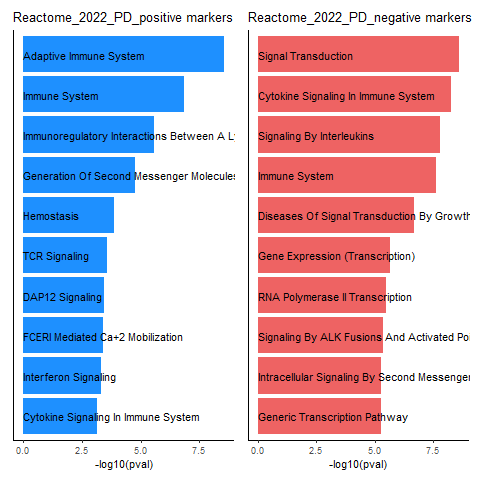

In [30]:
%%R
enrich.database <- "Reactome_2022"
p <- plot_enrichR_wrap_fun(
        ident.1="PD",
        ident.2="HC",
        pos.er = reactome_pos_mat,
        neg.er = reactome_neg_mat,
        enrich.database= enrich.database )

ggsave(plot=p,filename=paste0(resultdir,"BarPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=12)
ggsave(plot=p,filename=paste0(resultdir,"BarPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=12)
p

In [31]:
%%R
colnames(reactome_neg_mat)

 [1] "Reactome_2022.Term"                 "Reactome_2022.Overlap"             
 [3] "Reactome_2022.P.value"              "Reactome_2022.Adjusted.P.value"    
 [5] "Reactome_2022.Old.P.value"          "Reactome_2022.Old.Adjusted.P.value"
 [7] "Reactome_2022.Odds.Ratio"           "Reactome_2022.Combined.Score"      
 [9] "Reactome_2022.Genes"                "log10pval"                         
[11] "term"                               "ID"                                


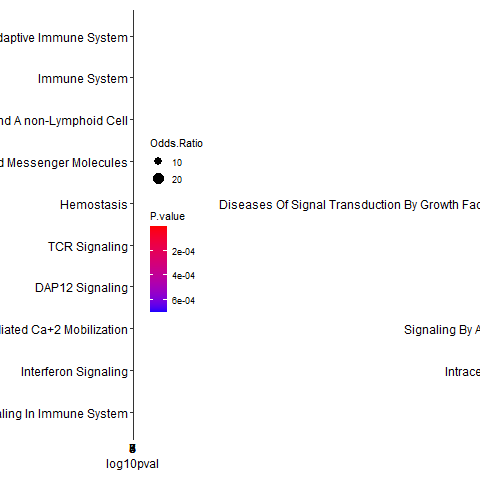

In [32]:
%%R
source("Functions.R")
enrich.database <- "Reactome_2022"
p <- dotplot_enrich_dim(pos_mat=reactome_pos_mat , neg_mat=reactome_neg_mat,n_paths=10)

ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=20,height=6)
ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=20,height=6)
p



# GO Pathway

## Possitive PD

In [33]:
%%R
source("Functions.R")
enrich.database <- c("GO_Biological_Process_2021")
mypos <- enrichR_wrap_fun_pos(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
pos.markers <- mypos$pos.markers
# ======= Enrichment matrix ===================
pos_mat <- mypos$pos_mat
print(pos_mat[1:3,1:2])
go_pos_mat <- pos_mat  
readr::write_csv(pos_mat,
    file=paste0(resultdir,CellType,"_POS_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
                           GO_Biological_Process_2021.Term
1               regulation of immune response (GO:0050776)
2           T cell receptor signaling pathway (GO:0050852)
3 antigen receptor-mediated signaling pathway (GO:0050851)
  GO_Biological_Process_2021.Overlap
1                        ratio 9/179
2                        ratio 8/158
3                        ratio 8/185


## Negative PD

In [34]:
%%R
source("Functions.R")
enrich.database<- c("GO_Biological_Process_2021")
myneg <- enrichR_wrap_fun_neg(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
neg.markers <- myneg$neg.markers
# ======= Enrichment matrix ===================
neg_mat <- myneg$neg_mat
print(neg_mat[1:3,1:2])
go_neg_mat <- neg_mat  
readr::write_csv(neg_mat,
    file=paste0(resultdir,CellType,"_NEG_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
                                                                                GO_Biological_Process_2021.Term
1          regulation of nuclear-transcribed mRNA catabolic process, deadenylation-dependent decay (GO:1900151)
2 positive regulation of nuclear-transcribed mRNA catabolic process, deadenylation-dependent decay (GO:1900153)
3                                                                     regulation of mRNA stability (GO:0043488)
  GO_Biological_Process_2021.Overlap
1                         ratio 5/15
2                         ratio 5/15
3                       ratio 10/146


Saving 12 x 6.67 in image
Saving 12 x 6.67 in image


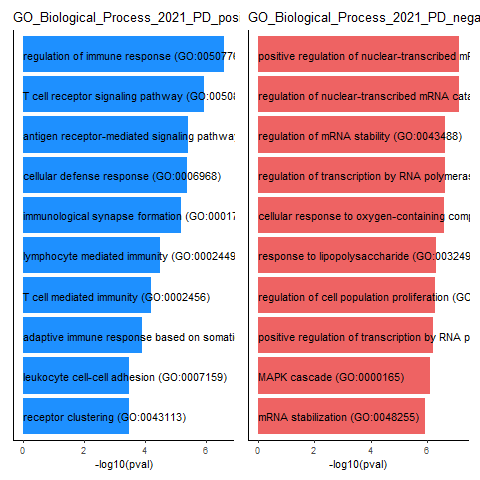

In [35]:
%%R
enrich.database <- "GO_Biological_Process_2021"
p <- plot_enrichR_wrap_fun(
        ident.1="PD",
        ident.2="HC",
        pos.er = go_pos_mat,
        neg.er = go_neg_mat,
        enrich.database= enrich.database )

ggsave(plot=p,filename=paste0(resultdir,
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=12)
ggsave(plot=p,filename=paste0(resultdir,
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=12)
p

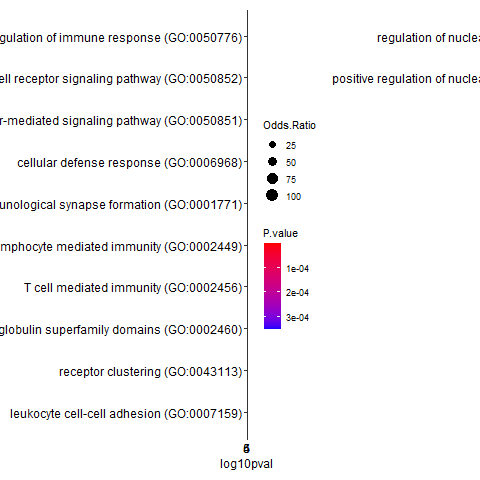

In [36]:
%%R
source("Functions.R")
enrich.database <- "GO_Biological_Process_2021"
p <- dotplot_enrich_dim(pos_mat=go_pos_mat , neg_mat=go_neg_mat,n_paths=10)

ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=20,height=6)
ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=20,height=6)
p

# Calculate RANKS based on FC

In [37]:
%%R
ranks_avg_log2FC<- tibble::deframe( DE_Seurat_mapped%>%  dplyr::select(entrezID , avg_log2FC   )) 
ranks_avg_log2FC[1:4]
gsea_kegg_log2FC <- gseKEGG(sort(ranks_avg_log2FC,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
readr::write_csv(as.data.frame(gsea_kegg_log2FC),
        file=paste0(resultdir,CellType,"_KEGG_GSEA_MinPct_",min_pct_threshold,"_Ranks_log2FC.csv"))

#  TOP UP GSEA KEGG

In [38]:
%%R
library(enrichplot)
sort_filt_gsea_kegg_log2FC <- gsea_kegg_log2FC[match(tolower(kegg_pos_mat$term[1:10]),tolower(gsea_kegg_log2FC$Description)),]

temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_KeggGSEAPlot/")
dir.create(temp_dir)
top_pos <- sort_filt_gsea_kegg_log2FC
for (row_iter in 1:10){
    id_term <- top_pos$ID[row_iter]
    text_term <- top_pos$Description[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_kegg_log2FC, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.threshold_",logfc.threshold,
            "_Ranks_log2FC_up.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] "Viral myocarditis"


[1] "Natural killer cell mediated cytotoxicity"
[1] "Human T-cell leukemia virus 1 infection"
[1] "Graft-versus-host disease"
[1] "Antigen processing and presentation"
[1] "Cell adhesion molecules"
[1] "T cell receptor signaling pathway"
[1] "Allograft rejection"
[1] "Type I diabetes mellitus"
[1] "Rap1 signaling pathway"


# TOP Down GSEA KEGG

In [39]:
%%R
sort_filt_gsea_kegg_log2FC <- gsea_kegg_log2FC[match(tolower(kegg_neg_mat$term[1:10]),tolower(gsea_kegg_log2FC$Description)),]
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_KeggGSEAPlot/")
dir.create(temp_dir)
top_neg <- sort_filt_gsea_kegg_log2FC
for (row_iter in 1:10){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$Description[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_kegg_log2FC, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.threshold_",logfc.threshold,
            "_Ranks_log2FC_down.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] "Osteoclast differentiation"


[1] "Hepatitis B"
[1] "cAMP signaling pathway"
[1] "Measles"
[1] "Apoptosis"
[1] "Colorectal cancer"
[1] "AGE-RAGE signaling pathway in diabetic complications"
[1] "T cell receptor signaling pathway"
[1] "Chronic myeloid leukemia"
[1] "Fluid shear stress and atherosclerosis"


In [40]:
%%R
library(ReactomePA)
require(clusterProfiler)
gsea_reactome_log2FC <- gsePathway(sort(ranks_avg_log2FC,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
readr::write_csv(as.data.frame(gsea_reactome_log2FC),
        file=paste0(resultdir,CellType,"_GSEA_MinPct_",min_pct_threshold,"_Ranks_log2FC.csv"))
gsea_reactome_log2FC[1:3,"Description"]

[1] "Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell"
[2] "Generation of second messenger molecules"                                
[3] "Signaling by Insulin receptor"                                           


# TOP UP GSEA REACTOME

In [41]:
%%R -i resultdir -i CellType
temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_GSEAPlot/")
dir.create(temp_dir)
top_pos <- reactome_pos_mat[1:10,]
for (row_iter in 1:10){
    id_term <- top_pos$ID[row_iter]
    text_term <- as.vector(top_pos$term)[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_reactome_log2FC, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    # Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.threshold_",logfc.threshold,
            "_Ranks_log2FC_up.pdf"), height = 8.5, width = 11)
    # Create a graphical object g here
    print(p)# print it
    # Stop writing to the PDF file
    dev.off()
}


[1] "Adaptive Immune System"


[1] "Immune System"
[1] "Immunoregulatory Interactions Between A Lymphoid And A non-Lymphoid Cell"
[1] "Generation Of Second Messenger Molecules"
[1] "Hemostasis"
[1] "TCR Signaling"
[1] "DAP12 Signaling"
[1] "FCERI Mediated Ca+2 Mobilization"
[1] "Interferon Signaling"
[1] "Cytokine Signaling In Immune System"


In [42]:
%%R
gsea_reactome_log2FC

#
# Gene Set Enrichment Analysis
#
#...@organism 	 human 
#...@setType 	 Reactome 
#...@keytype 	 ENTREZID 
#...@geneList 	 Named num [1:2627] 1.401 0.99 0.909 0.845 0.738 ...
 - attr(*, "names")= chr [1:2627] "10578" NA "972" "387357" ...
#...nPerm 	 10000 
#...pvalues adjusted by 'BH' with cutoff <1 
#...1838 enriched terms found
'data.frame':	1838 obs. of  11 variables:
 $ ID             : chr  "R-HSA-198933" "R-HSA-202433" "R-HSA-74752" "R-HSA-74751" ...
 $ Description    : chr  "Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell" "Generation of second messenger molecules" "Signaling by Insulin receptor" "Insulin receptor signalling cascade" ...
 $ setSize        : int  36 20 14 9 8 8 8 8 6 270 ...
 $ enrichmentScore: num  0.674 0.709 -0.775 -0.845 -0.853 ...
 $ NES            : num  2.23 2.05 -1.88 -1.84 -1.8 ...
 $ pvalue         : num  0.000283 0.000264 0.000658 0.00034 0.000688 ...
 $ p.adjust       : num  0.0929 0.0929 0.0929 0.0929 0.0929 ...
 $ qvalue  

## TOP Down GSEA REACTOME

In [43]:
%%R -i resultdir -i CellType
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_GSEAPlot/")
dir.create(temp_dir)
top_neg <- reactome_neg_mat[1:10,]
for (row_iter in 1:10){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$term[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_reactome_log2FC, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_log2FC_down.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] "Signal Transduction"


[1] "Cytokine Signaling In Immune System"
[1] "Signaling By Interleukins"
[1] "Immune System"
[1] "Diseases Of Signal Transduction By Growth Factor Receptors And Second Messengers"
[1] "Gene Expression (Transcription)"
[1] "RNA Polymerase II Transcription"
[1] "Signaling By ALK Fusions And Activated Point Mutants"
[1] "Intracellular Signaling By Second Messengers"
[1] "Generic Transcription Pathway"


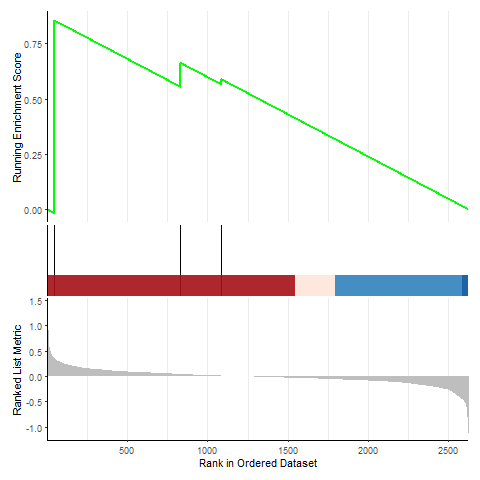

In [44]:
%%R -i resultdir -i CellType
p <- gseaplot2(gsea_reactome_log2FC, geneSetID = "R-HSA-8939246",subplots = 1:6,pvalue_table = F)
## Initiate writing to PDF file
pdf(paste0(resultdir,CellType,
       "_GSE_RUNX1_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_Ranks_log2FC.pdf"), height = 8.5, width = 11)
## Create a graphical object g here
print(p)# print it
## Stop writing to the PDF file
dev.off()
p

# Calculate RANKS based on Gene score

In [45]:
%%R
# Calculate RANKS based on genescore
ranks_avg_genescore<- tibble::deframe( DE_Seurat_mapped%>%  dplyr::select(entrezID , gene.score )) 
ranks_avg_genescore[1:4]
gsea_kegg_genescore <- gseKEGG(sort(ranks_avg_genescore,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
readr::write_csv(as.data.frame(gsea_kegg_log2FC),
        file=paste0(resultdir,CellType,"_KEGG_GSEA_MinPct_",min_pct_threshold,"_Ranks_genescore.csv"))

In [46]:
%%R
kegg_pos_mat[1,]

  KEGG_2021_Human.Term KEGG_2021_Human.Overlap KEGG_2021_Human.P.value
1    Viral myocarditis              ratio 7/60             1.82988e-08
  KEGG_2021_Human.Adjusted.P.value KEGG_2021_Human.Old.P.value
1                     2.982704e-06                           0
  KEGG_2021_Human.Old.Adjusted.P.value KEGG_2021_Human.Odds.Ratio
1                                    0                   28.49385
  KEGG_2021_Human.Combined.Score                       KEGG_2021_Human.Genes
1                       507.6586 SGCD;ITGB2;PRF1;HLA-A;ITGAL;EIF4G3;HLA-DRB1
  log10pval              term
1  7.737577 Viral myocarditis


In [47]:
%%R
library(enrichplot)
sort_filt_gsea_kegg_genescore <- gsea_kegg_genescore[match(tolower(kegg_pos_mat$term[1:10]),tolower(gsea_kegg_genescore$Description)),]

temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_KeggGSEAPlot/")
dir.create(temp_dir)
top_pos <- sort_filt_gsea_kegg_genescore
for (row_iter in 1:10){
    id_term <- top_pos$ID[row_iter]
    text_term <- top_pos$Description[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_kegg_genescore, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_up.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}


[1] "Viral myocarditis"


[1] "Natural killer cell mediated cytotoxicity"
[1] "Human T-cell leukemia virus 1 infection"
[1] "Graft-versus-host disease"
[1] "Antigen processing and presentation"
[1] "Cell adhesion molecules"
[1] "T cell receptor signaling pathway"
[1] "Allograft rejection"
[1] "Type I diabetes mellitus"
[1] "Rap1 signaling pathway"


In [48]:
%%R
sort_filt_gsea_kegg_genescore <- gsea_kegg_genescore[match(tolower(kegg_neg_mat$term[1:10]),tolower(gsea_kegg_genescore$Description)),]
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_KeggGSEAPlot/")
dir.create(temp_dir)
top_neg <- sort_filt_gsea_kegg_genescore
for (row_iter in 1:10){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$Description[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_kegg_genescore, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_down.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] "Osteoclast differentiation"


[1] "Hepatitis B"
[1] "cAMP signaling pathway"
[1] "Measles"
[1] "Apoptosis"
[1] "Colorectal cancer"
[1] "AGE-RAGE signaling pathway in diabetic complications"
[1] "T cell receptor signaling pathway"
[1] "Chronic myeloid leukemia"
[1] "Fluid shear stress and atherosclerosis"


In [49]:
%%R
library(ReactomePA)
require(clusterProfiler)
gsea_reactome_genescore <- gsePathway(sort(ranks_avg_genescore,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
readr::write_csv(as.data.frame(gsea_reactome_genescore),
        file=paste0(resultdir,CellType,"_GSEA_MinPct_",min_pct_threshold,"_Ranks_genescore.csv"))
gsea_reactome_genescore[1:3,"Description"]
# TOP UP GSEA REACTOME

[1] "Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell"
[2] "Signaling by Insulin receptor"                                           
[3] "Insulin receptor signalling cascade"                                     


In [50]:
%%R 
pos_IDs <- unlist(lapply( reactome_pos_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        ID <- splitted_str[grep("R-HSA",splitted_str)]
        return(ID)
    }))
reactome_pos_mat$ID <- pos_IDs
pos_Term <- unlist(lapply( reactome_pos_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        Term_text <- paste(splitted_str[1:indxex_id-1],collapse=" ")
        return(Term_text)
    }))
reactome_pos_mat$term <- pos_Term

neg_IDs <- unlist(lapply( reactome_neg_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        ID <- splitted_str[grep("R-HSA",splitted_str)]
        return(ID)
    }))
reactome_neg_mat$ID <- neg_IDs
neg_Term <- unlist(lapply( reactome_neg_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        Term_text <- paste(splitted_str[1:indxex_id-1],collapse=" ")
        return(Term_text)
    }))
reactome_neg_mat$term <- neg_Term

In [51]:
%%R -i resultdir -i CellType
temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_GSEAPlot/")
dir.create(temp_dir)
top_pos <- reactome_pos_mat[1:10,]
for (row_iter in 1:10){
    id_term <- top_pos$ID[row_iter]
    text_term <- as.vector(top_pos$term)[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_reactome_genescore, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    # Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_up.pdf"), height = 8.5, width = 11)
    # Create a graphical object g here
    print(p)# print it
    # Stop writing to the PDF file
    dev.off()
}

[1] "Adaptive Immune System"


[1] "Immune System"
[1] "Immunoregulatory Interactions Between A Lymphoid And A non-Lymphoid Cell"
[1] "Generation Of Second Messenger Molecules"
[1] "Hemostasis"
[1] "TCR Signaling"
[1] "DAP12 Signaling"
[1] "FCERI Mediated Ca+2 Mobilization"
[1] "Interferon Signaling"
[1] "Cytokine Signaling In Immune System"


In [52]:
%%R -i resultdir -i CellType
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_GSEAPlot/")
dir.create(temp_dir)
top_neg <- reactome_neg_mat[1:10,]
for (row_iter in 1:10){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$term[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_reactome_genescore, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_down.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] "Signal Transduction"


[1] "Cytokine Signaling In Immune System"
[1] "Signaling By Interleukins"
[1] "Immune System"
[1] "Diseases Of Signal Transduction By Growth Factor Receptors And Second Messengers"
[1] "Gene Expression (Transcription)"
[1] "RNA Polymerase II Transcription"
[1] "Signaling By ALK Fusions And Activated Point Mutants"
[1] "Intracellular Signaling By Second Messengers"
[1] "Generic Transcription Pathway"


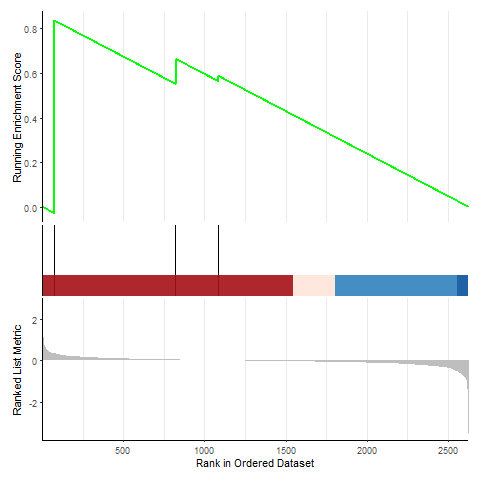

In [53]:
%%R -i resultdir -i CellType
p <- gseaplot2(gsea_reactome_genescore, geneSetID = "R-HSA-8939246",subplots = 1:6,pvalue_table = F)
## Initiate writing to PDF file
pdf(paste0(resultdir,CellType,
       "_GSE_RUNX1_pct_",min_pct_threshold,
        "_logfc.thres_",logfc.threshold,
        "_Ranks_gs.pdf"), height = 8.5, width = 11)
## Create a graphical object g here
print(p)# print it
## Stop writing to the PDF file
dev.off()
p

# KEGG GSEA ONLY POSSITIVE & ONLY NEG

In [54]:
%%R
library(enrichplot)
# Calculate RANKS based on genescore
ranks_genescore_pos<- tibble::deframe( DE_Seurat_mapped %>% filter(gene.score>0) %>%  dplyr::select(entrezID , gene.score )) 
ranks_genescore_pos[1:4]
gsea_kegg_genescore_pos <- gseKEGG(sort(ranks_genescore_pos,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
# ==== Keep only pos enriched
gsea_kegg_genescore_pos  <- gsea_kegg_genescore_pos %>% filter(enrichmentScore>=0)  
readr::write_csv(as.data.frame(gsea_kegg_genescore_pos),
        file=paste0(resultdir,CellType,"_GSEA_KEGG_MinPct_",min_pct_threshold,"_Ranks_genescore_POS.csv"))

# Calculate RANKS based on genescore
ranks_genescore_neg<- tibble::deframe( DE_Seurat_mapped %>% filter(gene.score<0) %>%  dplyr::select(entrezID , gene.score )) 
ranks_genescore_neg[1:4]
gsea_kegg_genescore_neg <- gseKEGG(sort(ranks_genescore_neg,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
# ==== Keep only pos enriched
gsea_kegg_genescore_neg  <- gsea_kegg_genescore_neg %>% filter(enrichmentScore<=0)  
readr::write_csv(as.data.frame(gsea_kegg_genescore_neg),
        file=paste0(resultdir,CellType,"_GSEA_KEGG_MinPct_",min_pct_threshold,"_Ranks_genescore_NEG.csv"))

In [55]:
%%R
# ====================================== PLOTTING  POS =====================================================================
temp_dir <- paste0(resultdir,"Top10_Upreg_GSEA_Kegg_GSEAPlot_ONLY_POS/")
dir.create(temp_dir)
for (row_iter in c(1:10)){
    id_term <- gsea_kegg_genescore_pos$ID[row_iter]
    text_term <- gsea_kegg_genescore_pos$Description[row_iter]
    p <- gseaplot2(gsea_kegg_genescore_pos, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_GS_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_pos.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

In [56]:
%%R
# ====================================== PLOTTING  POS =====================================================================
sort_filt_gsea_kegg_genescore <- gsea_kegg_genescore_pos[match(tolower(as.vector(kegg_pos_mat$term)[1:10]),tolower(gsea_kegg_genescore_pos$Description))%>% na.omit(),]
temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_KeggGSEAPlot_ONLY_POS/")
dir.create(temp_dir)
top_pos <- sort_filt_gsea_kegg_genescore
for (row_iter in 1:dim(sort_filt_gsea_kegg_genescore)[1]){
    id_term <- top_pos$ID[row_iter]
    text_term <- top_pos$Description[row_iter]
    p <- gseaplot2(gsea_kegg_genescore_pos, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GS_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_pos.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

In [57]:
%%R
# ====================================== PLOTTING  POS =====================================================================
temp_dir <- paste0(resultdir,"Top10_Upreg_GSEA_Kegg_GSEAPlot_ONLY_NEG/")
dir.create(temp_dir)
for (row_iter in c(1:10)){
    id_term <- gsea_kegg_genescore_neg$ID[row_iter]
    text_term <- gsea_kegg_genescore_neg$Description[row_iter]
    p <- gseaplot2(gsea_kegg_genescore_neg, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_GS_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_genescore_only_neg.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

In [58]:
%%R
# ====================================== PLOTTING  NEG =====================================================================
sort_filt_gsea_kegg_genescore <- gsea_kegg_genescore_neg[match(tolower(as.vector(kegg_neg_mat$term[1:10])),tolower(gsea_kegg_genescore_neg$Description))%>% na.omit(),]
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_KeggGSEAPlot_ONLY_NEG/")
dir.create(temp_dir)
top_neg <- sort_filt_gsea_kegg_genescore
for (row_iter in 1:dim(sort_filt_gsea_kegg_genescore)[1]){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$Description[row_iter]
    p <- gseaplot2(gsea_kegg_genescore_neg, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GS_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_neg.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

# Reactome GSEA ONLY POSSITIVE & ONLY NEG

In [59]:
%%R
library(ReactomePA)
require(clusterProfiler)
# Calculate RANKS based on genescore
ranks_genescore_pos<- tibble::deframe( DE_Seurat_mapped %>% filter(gene.score>0) %>%  dplyr::select(entrezID , gene.score )) 
ranks_genescore_pos[1:4]
gsea_Reactome_genescore_pos <- gsePathway(sort(ranks_genescore_pos,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
# ==== Keep only pos enriched
gsea_Reactome_genescore_pos  <- gsea_Reactome_genescore_pos %>% filter(enrichmentScore>=0)  
readr::write_csv(as.data.frame(gsea_Reactome_genescore_pos),
        file=paste0(resultdir,CellType,"_GSEA_Reactome_MinPct_",min_pct_threshold,"_Ranks_genescore_POS.csv"))

# Calculate RANKS based on genescore
ranks_genescore_neg<- tibble::deframe( DE_Seurat_mapped %>% filter(gene.score<0) %>%  dplyr::select(entrezID , gene.score )) 
ranks_genescore_neg[1:4]
gsea_Reactome_genescore_neg <- gsePathway(sort(ranks_genescore_neg,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
# ==== Keep only neg enriched
gsea_Reactome_genescore_neg  <- gsea_Reactome_genescore_neg %>% filter(enrichmentScore<=0)  
readr::write_csv(as.data.frame(gsea_Reactome_genescore_neg),
        file=paste0(resultdir,CellType,"_GSEA_Reactome_MinPct_",min_pct_threshold,"_Ranks_genescore_NEG.csv"))

In [60]:
%%R
head(gsea_Reactome_genescore_pos)

                         ID                                    Description
R-HSA-202733   R-HSA-202733 Cell surface interactions at the vascular wall
R-HSA-6803157 R-HSA-6803157                         Antimicrobial peptides
R-HSA-977068   R-HSA-977068           Termination of O-glycan biosynthesis
R-HSA-9683673 R-HSA-9683673                       Maturation of protein 3a
R-HSA-9694719 R-HSA-9694719                       Maturation of protein 3a
R-HSA-1280218 R-HSA-1280218                         Adaptive Immune System
              setSize enrichmentScore      NES      pvalue  p.adjust    qvalue
R-HSA-202733       15       0.7459749 1.608715 0.009436834 0.9420904 0.9420904
R-HSA-6803157       1       0.9991438 1.332171 0.003833737 0.9420904 0.9420904
R-HSA-977068        1       0.9957192 1.327605 0.011702986 0.9420904 0.9420904
R-HSA-9683673       1       0.9957192 1.327605 0.011702986 0.9420904 0.9420904
R-HSA-9694719       1       0.9957192 1.327605 0.011702986 0.9420904 0.9420904
R

In [61]:
%%R
head(gsea_Reactome_genescore_neg)

                         ID
R-HSA-74752     R-HSA-74752
R-HSA-1433557 R-HSA-1433557
R-HSA-442755   R-HSA-442755
R-HSA-111933   R-HSA-111933
R-HSA-111996   R-HSA-111996
R-HSA-111997   R-HSA-111997
                                                       Description setSize
R-HSA-74752                          Signaling by Insulin receptor       9
R-HSA-1433557                                 Signaling by SCF-KIT       9
R-HSA-442755  Activation of NMDA receptors and postsynaptic events      12
R-HSA-111933                             Calmodulin induced events       6
R-HSA-111996                                   Ca-dependent events       6
R-HSA-111997                                           CaM pathway       6
              enrichmentScore       NES      pvalue  p.adjust    qvalue rank
R-HSA-74752        -0.8744076 -1.680449 0.001904560 0.4788321 0.4597061   17
R-HSA-1433557      -0.8463501 -1.626528 0.004020739 0.4788321 0.4597061  142
R-HSA-442755       -0.8000842 -1.594808 0.005354

In [62]:
%%R
as.vector(reactome_pos_mat$term)[1:10]

 [1] "Adaptive Immune System"                                                  
 [2] "Immune System"                                                           
 [3] "Immunoregulatory Interactions Between A Lymphoid And A non-Lymphoid Cell"
 [4] "Generation Of Second Messenger Molecules"                                
 [5] "Hemostasis"                                                              
 [6] "TCR Signaling"                                                           
 [7] "DAP12 Signaling"                                                         
 [8] "FCERI Mediated Ca+2 Mobilization"                                        
 [9] "Interferon Signaling"                                                    
[10] "Cytokine Signaling In Immune System"                                     


In [63]:
%%R
tolower(gsea_Reactome_genescore_pos$Description)[1:10]

 [1] "cell surface interactions at the vascular wall"     
 [2] "antimicrobial peptides"                             
 [3] "termination of o-glycan biosynthesis"               
 [4] "maturation of protein 3a"                           
 [5] "maturation of protein 3a"                           
 [6] "adaptive immune system"                             
 [7] "immune system"                                      
 [8] "notch3 intracellular domain regulates transcription"
 [9] "pre-notch transcription and translation"            
[10] "regulation of beta-cell development"                


In [64]:
%%R
gsea_Reactome_genescore_pos$Description[1:10]

 [1] "Cell surface interactions at the vascular wall"     
 [2] "Antimicrobial peptides"                             
 [3] "Termination of O-glycan biosynthesis"               
 [4] "Maturation of protein 3a"                           
 [5] "Maturation of protein 3a"                           
 [6] "Adaptive Immune System"                             
 [7] "Immune System"                                      
 [8] "NOTCH3 Intracellular Domain Regulates Transcription"
 [9] "Pre-NOTCH Transcription and Translation"            
[10] "Regulation of beta-cell development"                


In [65]:
%%R
# ====================================== PLOTTING  POS =====================================================================
temp_dir <- paste0(resultdir,"Top10_Upreg_GSEA_Reactome_GSEAPlot_ONLY_POS/")
dir.create(temp_dir)
for (row_iter in c(1:10)){
    id_term <- gsea_Reactome_genescore_pos$ID[row_iter]
    text_term <- gsea_Reactome_genescore_pos$Description[row_iter]
    p <- gseaplot2(gsea_Reactome_genescore_pos, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_GS_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_pos.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

In [66]:
%%R
# ====================================== PLOTTING  POS =====================================================================
sort_filt_gsea_Reactome_genescore <- gsea_Reactome_genescore_pos[match(tolower(as.vector(reactome_pos_mat$term))[1:10],tolower(gsea_Reactome_genescore_pos$Description))%>% na.omit(),]
temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_Reactome_GSEAPlot_ONLY_POS/")
dir.create(temp_dir)
print(dim(sort_filt_gsea_Reactome_genescore))
top_pos <- sort_filt_gsea_Reactome_genescore
for (row_iter in 1:dim(sort_filt_gsea_Reactome_genescore)[1]){
    id_term <- top_pos$ID[row_iter]
    text_term <- top_pos$Description[row_iter]
    p <- gseaplot2(gsea_Reactome_genescore_pos, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_pos.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] 10 11


In [67]:
%%R
# ====================================== PLOTTING  neg =====================================================================
temp_dir <- paste0(resultdir,"Top10_Downreg_GSEA_Reactome_GSEAPlot_ONLY_NEG/")
dir.create(temp_dir)

for (row_iter in c(1:10)){
    id_term <- gsea_Reactome_genescore_neg$ID[row_iter]
    text_term <- gsea_Reactome_genescore_neg$Description[row_iter]
    p <- gseaplot2(gsea_Reactome_genescore_neg, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_GS_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_neg.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

In [68]:
%%R
# ====================================== PLOTTING  NEG =====================================================================
sort_filt_gsea_Reactome_genescore <- gsea_Reactome_genescore_neg[match(tolower(as.vector(reactome_neg_mat$term)[1:10]),tolower(gsea_Reactome_genescore_neg$Description))%>% na.omit(),]
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_Reactome_GSEAPlot_ONLY_NEG/")
dir.create(temp_dir)
print(dim(sort_filt_gsea_Reactome_genescore))

top_neg <- sort_filt_gsea_Reactome_genescore
for (row_iter in 1:dim(sort_filt_gsea_Reactome_genescore)[1]){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$Description[row_iter]
    p <- gseaplot2(gsea_Reactome_genescore_neg, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_neg.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] 10 11


# END

In [69]:
%%R
sessionInfo()

R version 4.2.2 (2022-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22621)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ReactomePA_1.42.0           enrichplot_1.18.4          
 [3] EnhancedVolcano_1.16.0      ggrepel_0.9.2              
 [5] clusterProfiler_4.6.2       org.Hs.eg.db_3.16.0        
 [7] AnnotationDbi_1.60.2        forcats_1.0.0              
 [9] purrr_1.0.1                 readr_2.1.3                
[11] tidyr_1.3.0                 tibble_3.2.0               
[13] tidyverse_1.3.2             enrichR_3.2                
[15] DESeq2_1.38.3               dittoSeq_1.10.0      